# This notebook performs translation on key frames

In [2]:
import argparse
import os
import random

import cv2
import einops
import numpy as np
import imageio
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from blendmodes.blend import BlendType, blendLayers
from PIL import Image
from pytorch_lightning import seed_everything
from safetensors.torch import load_file
from skimage import exposure
from IPython.display import display

import src.import_util  
from deps.ControlNet.annotator.canny import CannyDetector
from deps.ControlNet.annotator.hed import HEDdetector
from deps.ControlNet.annotator.util import HWC3, resize_image
from deps.ControlNet.cldm.cldm import ControlLDM
from deps.ControlNet.cldm.model import create_model, load_state_dict
from deps.gmflow.gmflow.gmflow import GMFlow
from flow.flow_utils import get_warped_and_mask
from src.config import RerenderConfig
from src.controller import AttentionControl
from src.ddim_v_hacked import DDIMVSampler
from src.img_util import find_flat_region, numpy2tensor
from src.video_util import frame_to_video, get_fps, prepare_frames

/mnt/lustre/syang/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.
No module 'xformers'. Proceeding without it.


In [3]:
blur = T.GaussianBlur(kernel_size=(9, 9), sigma=(18, 18))
totensor = T.PILToTensor()

def setup_color_correction(image):
    correction_target = cv2.cvtColor(np.asarray(image.copy()),
                                     cv2.COLOR_RGB2LAB)
    return correction_target

def apply_color_correction(correction, original_image):
    image = Image.fromarray(
        cv2.cvtColor(
            exposure.match_histograms(cv2.cvtColor(np.asarray(original_image),
                                                   cv2.COLOR_RGB2LAB),
                                      correction,
                                      channel_axis=2),
            cv2.COLOR_LAB2RGB).astype('uint8'))

    image = blendLayers(image, original_image, BlendType.LUMINOSITY)

    return image

In [ ]:
# load optical flow model
flow_model = GMFlow(
    feature_channels=128,
    num_scales=1,
    upsample_factor=8,
    num_head=1,
    attention_type='swin',
    ffn_dim_expansion=4,
    num_transformer_layers=6,
).to('cuda')

checkpoint = torch.load('models/gmflow_sintel-0c07dcb3.pth', map_location=lambda storage, loc: storage)
weights = checkpoint['model'] if 'model' in checkpoint else checkpoint
flow_model.load_state_dict(weights, strict=False)
flow_model.eval()

In [5]:
control_type = 'canny'
canny_low = 50
canny_high = 100
sd_model = './models/revAnimated_v11.safetensors'

inner_strength = 0.9
cross_period = [0, 1]    # cross-frame attention
warp_period = [0, 0.1]   # shape-aware cross-frame fusion 
mask_period = [0.5, 0.8] # pixel-aware cross-frame fusion 
ada_period = [0.8, 1]    # adaptive color adjustment

In [6]:
# Load SD and controlnet models
if control_type == 'HED':
    detector = HEDdetector()
elif control_type == 'canny':
    canny_detector = CannyDetector()
    def apply_canny(x):
        return canny_detector(x, canny_low, canny_high)
    detector = apply_canny

model: ControlLDM = create_model(
    './deps/ControlNet/models/cldm_v15.yaml').cpu()
if control_type == 'HED':
    model.load_state_dict(
        load_state_dict('./models/control_sd15_hed.pth', location='cuda'))
elif control_type == 'canny':
    model.load_state_dict(load_state_dict('./models/control_sd15_canny.pth', location='cuda'))
model = model.cuda()

# load LoRA or finetuned model
model_ext = os.path.splitext(sd_model)[1]
if model_ext == '.safetensors':
    model.load_state_dict(load_file(sd_model), strict=False)
elif model_ext == '.ckpt' or model_ext == '.pth':
    model.load_state_dict(torch.load(sd_model)['state_dict'], strict=False)

# load VAE
model.first_stage_model.load_state_dict(torch.load('./models/vae-ft-mse-840000-ema-pruned.ckpt')['state_dict'], strict=False)

# get the sampler
ddim_v_sampler = DDIMVSampler(model)

# get the temporal consistency controller
controller = AttentionControl(0.9, mask_period, cross_period, ada_period, warp_period)

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./deps/ControlNet/models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]


In [34]:
seed = 0
ddim_steps = 20
filename = './data/pexels-koolshooters-7322716.mp4'
savename = './result.mp4'
scale = 7.5
image_resolution = 512
num_samples = 1

prompt = 'a beautiful woman in CG style'
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

control_strength = [0.7] * 13
model.control_scales = control_strength
keyframe_count = 11 
interval = 10
strength = 0.75
strength = 1 - strength
color_preserve = True
style_update_freq = 1
firstx0 = True # warp the first frame or previous frame in shape-aware cross-frame fusion 
pixelfusion = True # whether using pixel-aware cross-frame fusion 
smooth_boundary = True # smooth the fusion boundary to avoid artifacts
mask_strength = 0.5 # smooth the fusion region to avoid artifacts

In [35]:
video_cap = cv2.VideoCapture(filename)
keyframe_count = min(keyframe_count, (video_cap.get(cv2.CAP_PROP_FRAME_COUNT)-2) // interval)
fps = max(video_cap.get(cv2.CAP_PROP_FPS)//interval, 1)

# first key frame

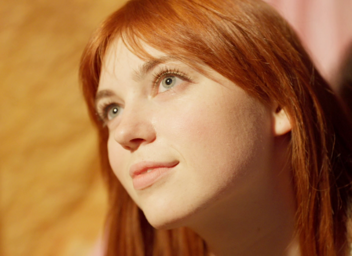

processing key frame #000...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


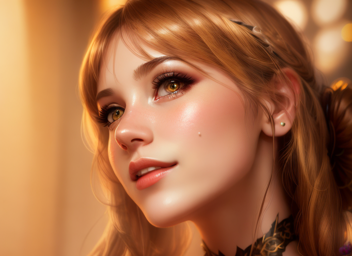

In [36]:
with torch.no_grad():
    success, frame = video_cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = resize_image(HWC3(frame), image_resolution)
    H, W, C = img.shape
    display(Image.fromarray(img).resize((W//2,H//2)))
    print('processing key frame #%03d...'%(0))
    
    x0_strength = strength if color_preserve else -1
    img_ = numpy2tensor(img)
    encoder_posterior = model.encode_first_stage(img_.cuda()) 
    x0 = model.get_first_stage_encoding(encoder_posterior).detach()
    detected_map = detector(img)
    detected_map = HWC3(detected_map)    
    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()
    cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
    un_cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
    shape = (4, H // 8, W // 8)
    
    controller.set_task('initfirst')
    seed_everything(seed)
    samples, intermediates = ddim_v_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=0,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond,
                                                 controller = controller,
                                                 x0=x0, strength=x0_strength)
    x_samples = model.decode_first_stage(samples)
    x_samples_np = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
    
    if not color_preserve:
        color_corrections = setup_color_correction(Image.fromarray(x_samples_np[0]))
        img_ = apply_color_correction(color_corrections, Image.fromarray(img))
        img_ = totensor(img_).unsqueeze(0)[:,:3] / 127.5 - 1
        encoder_posterior = model.encode_first_stage(img_.cuda()) 
        x0 = model.get_first_stage_encoding(encoder_posterior).detach()
        
        controller.set_task('initfirst')
        seed_everything(seed)
        samples, intermediates = ddim_v_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=0,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond,
                                                     controller = controller,
                                                     x0=x0, strength=strength)
        x_samples = model.decode_first_stage(samples) 
        x_samples_np = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
    
    pre_result = x_samples
    pre_img = img
    first_result = pre_result
    first_img = pre_img
    display(Image.fromarray(x_samples_np[0]).resize((W//2,H//2)))

# other key frames

processing key frame #001...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


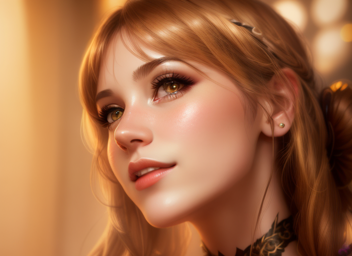

processing key frame #002...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


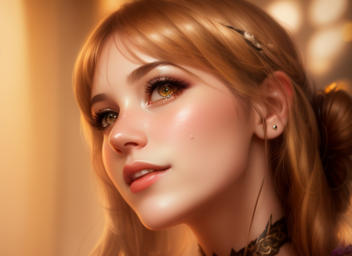

processing key frame #003...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


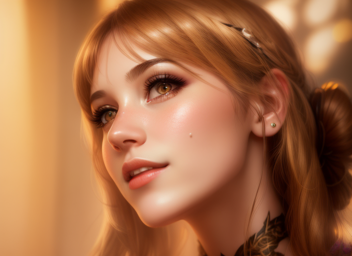

processing key frame #004...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


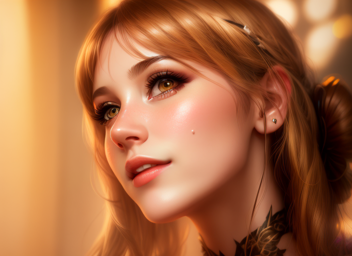

processing key frame #005...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


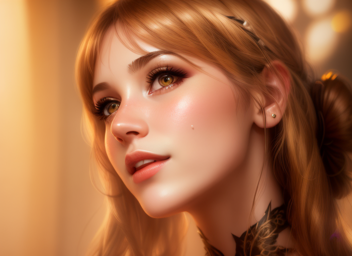

processing key frame #006...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


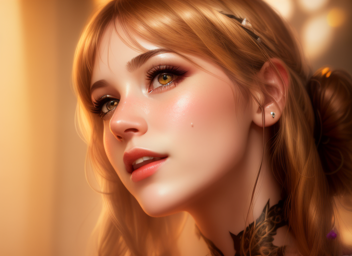

processing key frame #007...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


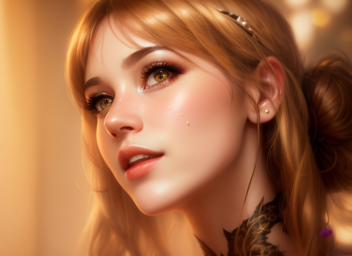

processing key frame #008...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


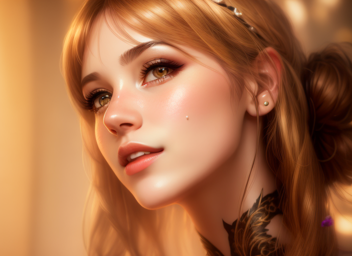

processing key frame #009...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


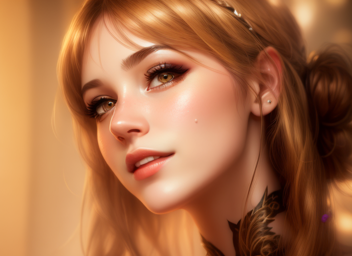

processing key frame #010...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


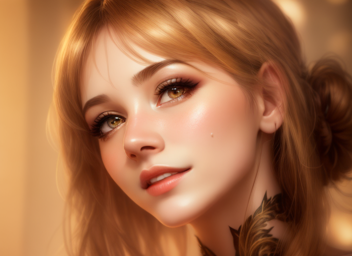

processing key frame #011...


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


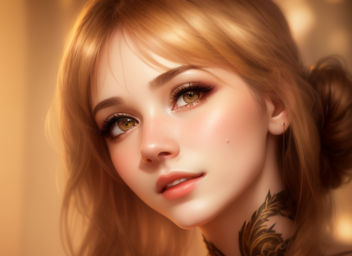

In [37]:
results = []
for i in range(keyframe_count):
    success, frame = video_cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)   
    print('processing key frame #%03d...'%(i+1))
    img = resize_image(HWC3(frame), image_resolution)
    for _ in range(interval-1):
        success, frame = video_cap.read()
        
    if color_preserve:
        img_ = numpy2tensor(img)
    else:
        img_ = apply_color_correction(color_corrections, Image.fromarray(img))
        img_ = totensor(img_).unsqueeze(0)[:,:3] / 127.5 - 1    
    encoder_posterior = model.encode_first_stage(img_.cuda())
    x0 = model.get_first_stage_encoding(encoder_posterior).detach()    
    
    detected_map = detector(img)
    detected_map = HWC3(detected_map)    
    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()    
    cond["c_concat"] = [control]
    un_cond["c_concat"] = [control]    

    image1 = torch.from_numpy(pre_img).permute(2, 0, 1).float() 
    image2 = torch.from_numpy(img).permute(2, 0, 1).float() 
    warped_pre, bwd_occ_pre, bwd_flow_pre = get_warped_and_mask(flow_model, image1, image2, pre_result, False)
    blend_mask_pre = blur(F.max_pool2d(bwd_occ_pre, kernel_size=9, stride=1, padding=4))
    blend_mask_pre = torch.clamp(blend_mask_pre + bwd_occ_pre, 0, 1)
    
    image1 = torch.from_numpy(first_img).permute(2, 0, 1).float() 
    warped_0, bwd_occ_0, bwd_flow_0 = get_warped_and_mask(flow_model, image1, image2, first_result, False)
    blend_mask_0 = blur(F.max_pool2d(bwd_occ_0, kernel_size=9, stride=1, padding=4))
    blend_mask_0 = torch.clamp(blend_mask_0 + bwd_occ_0, 0, 1)
    
    if firstx0:
        mask = 1 - F.max_pool2d(blend_mask_0, kernel_size=8)
        controller.set_warp(F.interpolate(bwd_flow_0 / 8.0, scale_factor=1./8, mode='bilinear'), mask)
    else:
        mask = 1 - F.max_pool2d(blend_mask_pre, kernel_size=8)
        controller.set_warp(F.interpolate(bwd_flow_pre / 8.0, scale_factor=1./8, mode='bilinear'), mask)
    
    controller.set_task('keepx0, keepstyle', 1)
    seed_everything(seed)
    samples, intermediates = ddim_v_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=0,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond,
                                                 controller = controller,
                                                 x0=x0, strength=strength)
    direct_result = model.decode_first_stage(samples)  
    
    if not pixelfusion:
        pre_result = direct_result
        pre_img = img
        x_samples_np = (einops.rearrange(direct_result, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        results+= [x_samples_np[0]]
        display(Image.fromarray(x_samples_np[0]).resize((W//2,H//2)))
        continue
    
    blend_results = (1-blend_mask_pre) * warped_pre + blend_mask_pre * direct_result
    blend_results = (1-blend_mask_0) * warped_0 + blend_mask_0 * blend_results
    
    bwd_occ = 1-torch.clamp(1-bwd_occ_pre + 1-bwd_occ_0, 0, 1)
    blend_mask= blur(F.max_pool2d(bwd_occ, kernel_size=9, stride=1, padding=4))
    blend_mask = 1-torch.clamp(blend_mask + bwd_occ, 0, 1)
    
    encoder_posterior = model.encode_first_stage(blend_results)
    xtrg = model.get_first_stage_encoding(encoder_posterior).detach()
    blend_results_rec = model.decode_first_stage(xtrg) 
    encoder_posterior = model.encode_first_stage(blend_results_rec)
    xtrg_rec = model.get_first_stage_encoding(encoder_posterior).detach()
    xtrg_ = (xtrg + 1 * (xtrg - xtrg_rec))
    blend_results_rec_new = model.decode_first_stage(xtrg_)
    tmp = (abs(blend_results_rec_new-blend_results).mean(dim=1, keepdims=True)>0.25).float()
    mask_x = F.max_pool2d((F.interpolate(tmp, scale_factor=1/8., mode='bilinear')>0).float(), kernel_size=3, stride=1, padding=1)
     
    mask = (1 - F.max_pool2d(1-blend_mask, kernel_size=8))
    if smooth_boundary:
        noise_rescale = find_flat_region(mask)
    else:
        noise_rescale = torch.ones_like(mask)
    masks = []
    for j in range(ddim_steps):
        if j <= ddim_steps * mask_period[0] or j >= ddim_steps * mask_period[1]:
            masks += [None]
        else:
            masks += [mask * mask_strength]
    xtrg = (xtrg + (1-mask_x) * (xtrg - xtrg_rec)) * mask
    
    tasks = 'keepstyle, keepx0'
    if not firstx0:
        tasks += ', updatex0'
    if i % style_update_freq == 0:
        tasks += ', updatestyle'
    controller.set_task(tasks, 1)
    
    seed_everything(seed)
    samples, intermediates = ddim_v_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=0,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond,
                                                 controller = controller,
                                                 x0=x0, strength=strength,
                                                 xtrg=xtrg, mask=masks, noise_rescale=noise_rescale)
    x_samples = model.decode_first_stage(samples)
    pre_result = x_samples
    pre_img = img
    
    x_samples_np = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
    results+= [x_samples_np[0]]
    display(Image.fromarray(x_samples_np[0]).resize((W//2,H//2)))

In [38]:
imageio.mimsave(savename, results, fps=fps)